In [2]:
from torch.utils.data import DataLoader
from resnet import ResNet, ResNet2 # Assuming resnet.py contains your ResNet model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, f1_score
import numpy as np
from custom_dataset import FinalDataset, BeatsDataset
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
import copy
import itertools
from sklearn.metrics import RocCurveDisplay, roc_curve
from captum.attr import LayerGradCam, LayerAttribution
from captum.attr import visualization as viz # Per la visualizzazione (opzionale)
import os


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
file_path = "./data/Dataset.hdf5"
dataset = FinalDataset(file_path, downsample=True, majority_ratio=0.50)

In [5]:
random_state = 42
batch_size = 256
train_val_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=0.15,
    random_state=random_state,
    stratify=dataset.get_labels()
)
train_val_idx.sort()
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.17647,
    random_state=random_state,
    stratify=dataset.labels[train_val_idx]
)

train_loader = DataLoader(FinalDataset("./data/Dataset.hdf5", indices=dataset.indices[train_idx]), batch_size=1, shuffle=True)
val_loader   = DataLoader(FinalDataset("./data/Dataset.hdf5", indices=dataset.indices[val_idx]),   batch_size=1, shuffle=False)
test_loader  = DataLoader(FinalDataset("./data/Dataset.hdf5", indices=dataset.indices[test_idx]),   batch_size=1, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [38]:
for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    print(f"Batch shape: {x.shape}, Labels shape: {y.shape}")
    break

Batch shape: torch.Size([256, 12, 72]), Labels shape: torch.Size([256, 1])


In [9]:
old_model = ResNet(12, 64)
old_model.load_state_dict(torch.load("model_RETE_BEATS_BEST_GRID_SEARCH_FULL_EPOCHS_95.pth", map_location=device))
old_model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'model_RETE_BEATS_BEST_GRID_SEARCH_FULL_EPOCHS_95.pth'

Best threshold (from ROC, closest to (0,1)): 0.4813


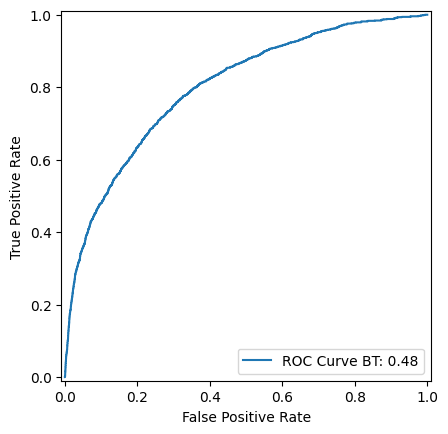

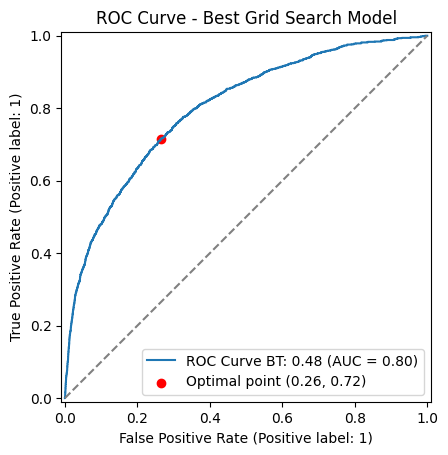

<Figure size 1000x500 with 0 Axes>

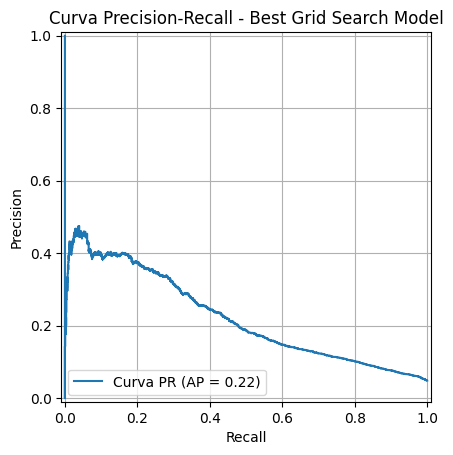

Best threshold (from PR, maximizing F1-score): 0.7783
Precision at optimal PR threshold: 0.2893
Recall at optimal PR threshold: 0.3389
F1-score at optimal PR threshold: 0.3122

--- Metrics with Best F1-Score Threshold (0.7783) ---
Confusion Matrix:
[[22322   990]
 [  787   402]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9659    0.9575    0.9617     23312
         1.0     0.2888    0.3381    0.3115      1189

    accuracy                         0.9275     24501
   macro avg     0.6274    0.6478    0.6366     24501
weighted avg     0.9331    0.9275    0.9302     24501


--- Metrics with Threshold Closest to 0.9 Specificity (0.6394) ---
Confusion Matrix:
[[20977  2335]
 [  619   570]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9713    0.8998    0.9342     23312
         1.0     0.1962    0.4794    0.2785      1189

    accuracy                         0.8794     24501
   macro avg

In [31]:
all_preds, all_targets = [], []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        pred = old_model(X)
        all_preds.append(pred.cpu())
        all_targets.append(y.cpu())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

probabilities = torch.sigmoid(all_preds)
y_true_numpy = all_targets.numpy()
probabilities_numpy = probabilities.numpy()

# --- ROC Curve Analysis (for plotting) ---
fpr, tpr, thresholds = roc_curve(y_true_numpy, probabilities_numpy)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
min_distance_idx = np.argmin(distances)
optimal_fpr, optimal_tpr = fpr[min_distance_idx], tpr[min_distance_idx]
best_threshold_roc = thresholds[min_distance_idx]
print(f"Best threshold (from ROC, closest to (0,1)): {best_threshold_roc:.4f}")

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=None, estimator_name=f"ROC Curve BT: {best_threshold_roc:.2f}")
roc_display.plot()

RocCurveDisplay.from_predictions(all_targets, probabilities, name=f"ROC Curve BT: {best_threshold_roc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.scatter(optimal_fpr, optimal_tpr, color='red', label=f'Optimal point ({optimal_fpr:.2f}, {optimal_tpr:.2f})')
plt.title('ROC Curve - Best Grid Search Model')
plt.legend()
plt.show()

# --- Precision-Recall Curve Analysis (for plotting and F1 threshold) ---
precision, recall, pr_thresholds = precision_recall_curve(y_true_numpy, probabilities_numpy)

plt.figure(figsize=(10, 5))
PrecisionRecallDisplay.from_predictions(all_targets, probabilities, name="Curva PR")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall - Best Grid Search Model')
plt.grid(True)
plt.show()

# Determine best threshold for F1 from PR curve
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = pr_thresholds[optimal_f1_idx] 

print(f"Best threshold (from PR, maximizing F1-score): {best_threshold_f1:.4f}")
print(f"Precision at optimal PR threshold: {precision[optimal_f1_idx]:.4f}")
print(f"Recall at optimal PR threshold: {recall[optimal_f1_idx]:.4f}")
print(f"F1-score at optimal PR threshold: {f1_scores[optimal_f1_idx]:.4f}")

### Metrics with Best F1-Score Threshold

print(f"\n--- Metrics with Best F1-Score Threshold ({best_threshold_f1:.4f}) ---")
predicted_f1 = (probabilities_numpy > best_threshold_f1).astype(int)
cm_f1 = confusion_matrix(y_true_numpy, predicted_f1, labels=[0, 1])
print("Confusion Matrix:")
print(cm_f1)
report_f1 = classification_report(y_true_numpy, predicted_f1, digits=4, zero_division=0)
print("Classification Report:")
print(report_f1)

### Finding Threshold Closest to 0.9 Specificity and Its Metrics

target_specificity = 0.9
closest_threshold_specificity = None
min_specificity_diff = float('inf') # Initialize with a large value

# Iterate through all available thresholds to find the one that gives specificity
# closest to the target specificity.
for t in thresholds: 
    predicted = (probabilities_numpy > t).astype(int)
    cm = confusion_matrix(y_true_numpy, predicted, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    # Handle case where tn + fp might be zero (no negative samples)
    current_specificity = tn / (tn + fp + 1e-10) 

    specificity_diff = abs(current_specificity - target_specificity)

    # Update if this threshold gives a smaller absolute difference
    if specificity_diff < min_specificity_diff:
        min_specificity_diff = specificity_diff
        closest_threshold_specificity = t

if closest_threshold_specificity is not None:
    print(f"\n--- Metrics with Threshold Closest to {target_specificity:.1f} Specificity ({closest_threshold_specificity:.4f}) ---")
    predicted_closest_specificity = (probabilities_numpy > closest_threshold_specificity).astype(int)
    cm_closest_specificity = confusion_matrix(y_true_numpy, predicted_closest_specificity, labels=[0, 1])
    print("Confusion Matrix:")
    print(cm_closest_specificity)
    report_closest_specificity = classification_report(y_true_numpy, predicted_closest_specificity, digits=4, zero_division=0)
    print("Classification Report:")
    print(report_closest_specificity)
    
    tn, fp, fn, tp = cm_closest_specificity.ravel()
    actual_specificity = tn / (tn + fp + 1e-10)
    print(f"Actual Specificity at this threshold: {actual_specificity:.4f}")
    
    # Calculate precision, recall, and F1-score for the 0.9 specificity threshold
    precision_spec = tp / (tp + fp + 1e-10)
    recall_spec = tp / (tp + fn + 1e-10)
    f1_spec = 2 * (precision_spec * recall_spec) / (precision_spec + recall_spec + 1e-10)
    
    print(f"\nThreshold (closest to 0.9 specificity): {closest_threshold_specificity:.4f}")
    print(f"Precision at 0.9 specificity threshold: {precision_spec:.4f}")
    print(f"Recall at 0.9 specificity threshold: {recall_spec:.4f}")
    print(f"F1-score at 0.9 specificity threshold: {f1_spec:.4f}")
else:
    print(f"\nCould not find a suitable threshold for {target_specificity:.1f} specificity.")

In [71]:
dataset = FinalDataset("./data/Dataset.hdf5")
for signal,label in dataset:
    counter = 0
    if label == 1:
        if counter != 0:
            break
        counter += 1
        break

In [6]:
model = ResNet(12, 64)
model.load_state_dict(torch.load("./results/model_RETE_FINALE_BEST_GRID_SEARCH_FULL_EPOCHS.pth"))
print(model)

ResNet(
  (Conv1): Conv1d(12, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (BatchNorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU1): ReLU()
  (ResBlocks): Sequential(
    (0): ResBlock1(
      (MaxPool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (Conv1_A): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (Conv1_B): Conv1d(64, 128, kernel_size=(17,), stride=(2,), padding=(7,))
      (BatchNorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ReLU1): ReLU()
      (Dropout1): Dropout(p=0.5, inplace=False)
      (Conv2_B): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (BatchNorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ReLU2): ReLU()
      (Dropout2): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock1(
      (MaxPool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, c

In [40]:
signal_unsqueezed = signal.unsqueeze(0)
signal_unsqueezed.shape
label_unsqueezed = label.unsqueeze(0)
label_unsqueezed.shape

torch.Size([1, 1])

L'attribuzione ha una risoluzione diversa. Eseguo l'upsampling...
Forma attribuzione post-ridimensionamento: torch.Size([4000])


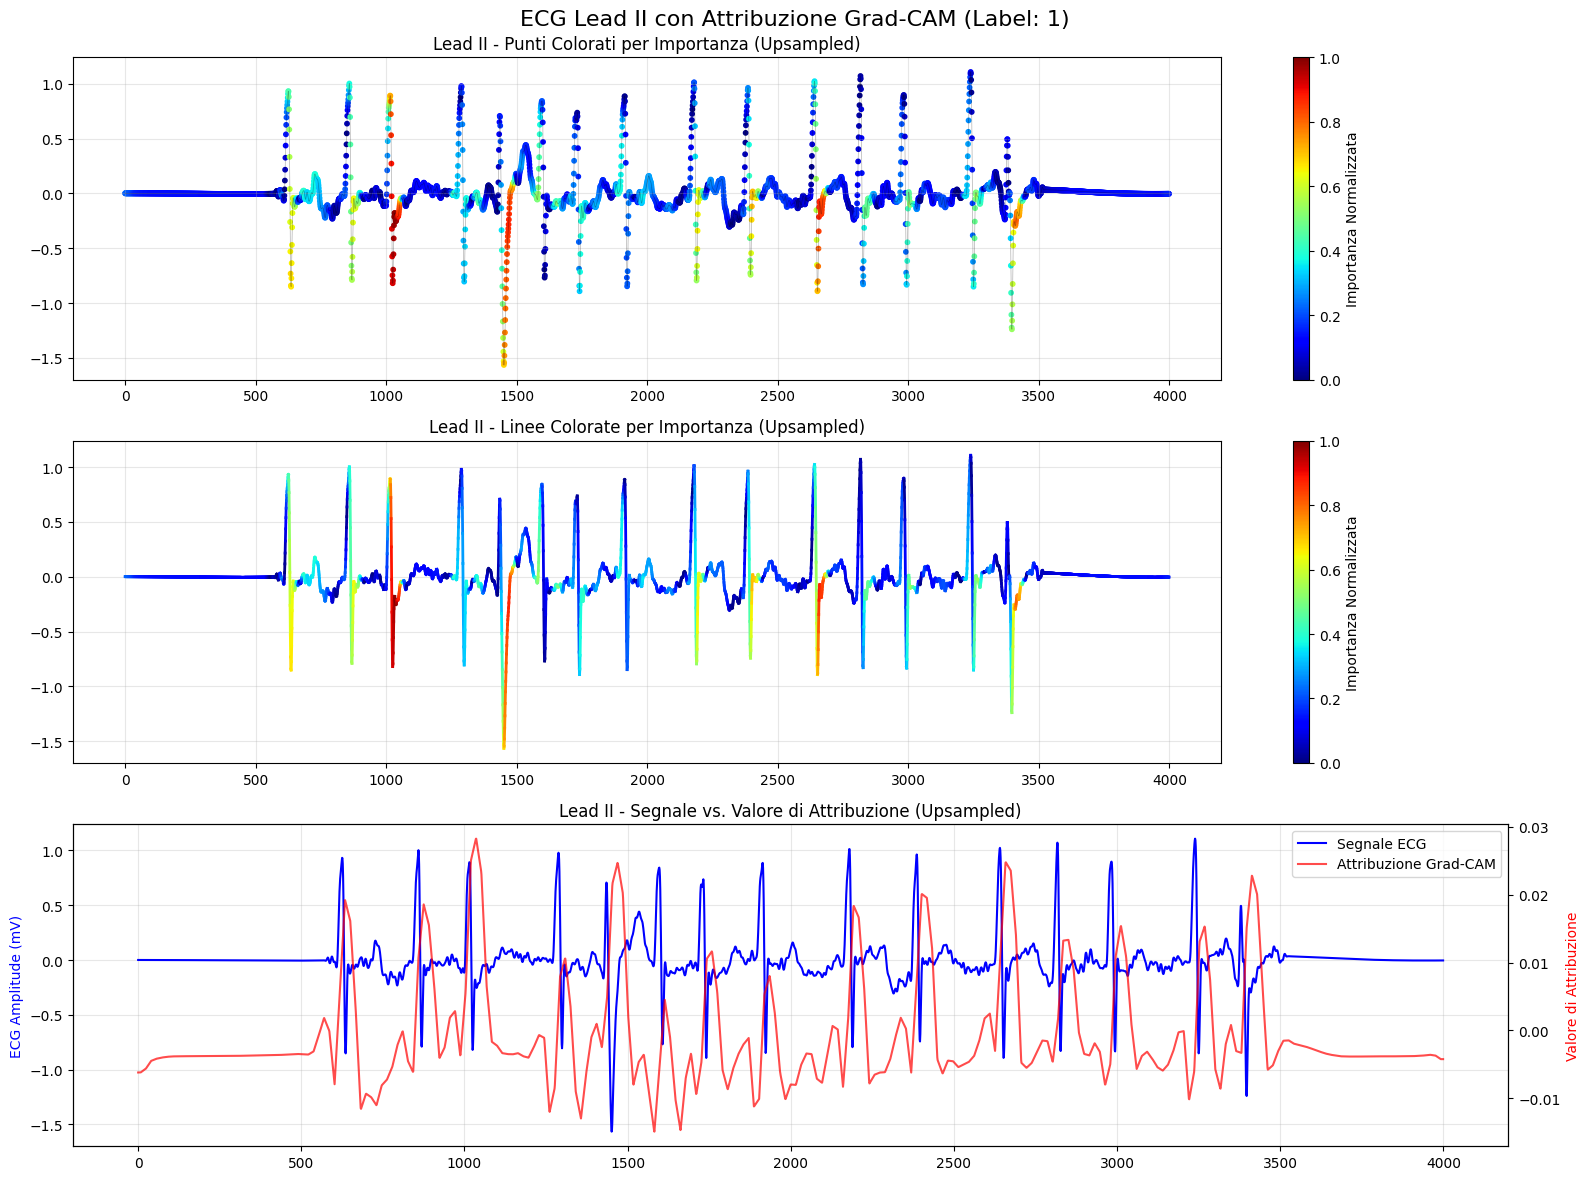

L'attribuzione ha una risoluzione diversa. Eseguo l'upsampling...
Forma attribuzione post-ridimensionamento: torch.Size([4000])


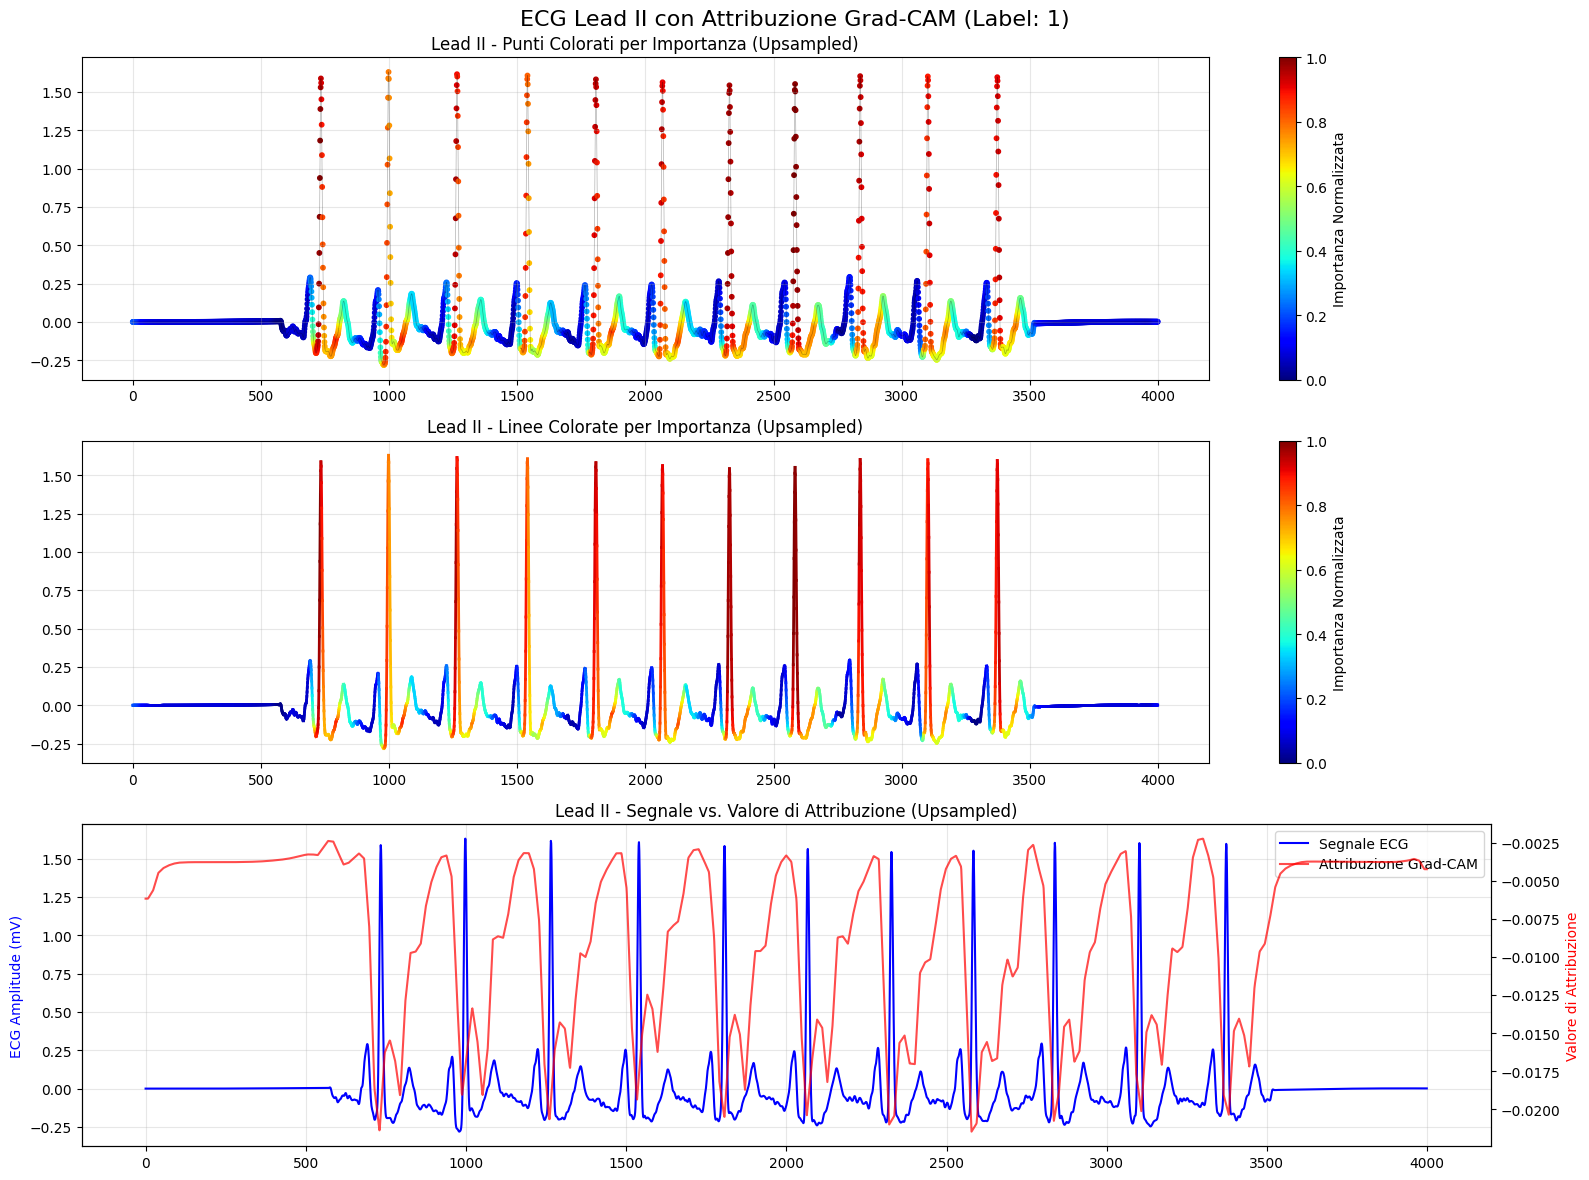

L'attribuzione ha una risoluzione diversa. Eseguo l'upsampling...
Forma attribuzione post-ridimensionamento: torch.Size([4000])


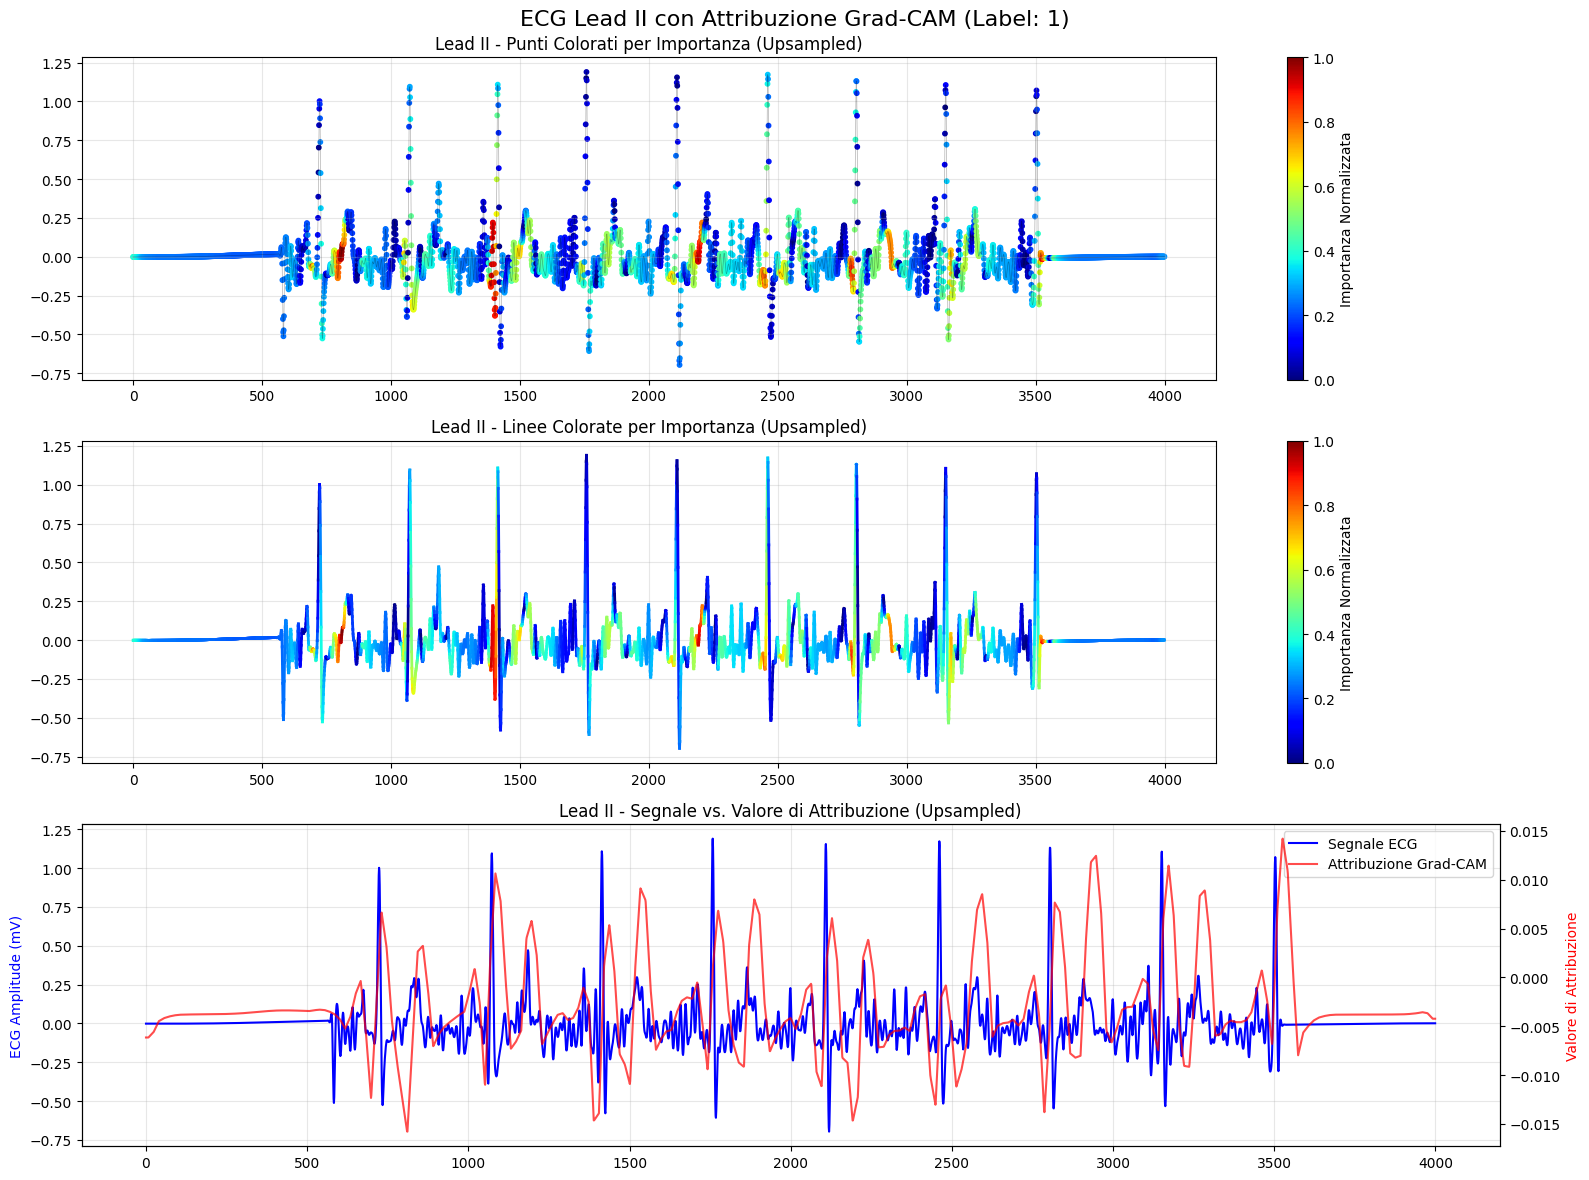

L'attribuzione ha una risoluzione diversa. Eseguo l'upsampling...
Forma attribuzione post-ridimensionamento: torch.Size([4000])


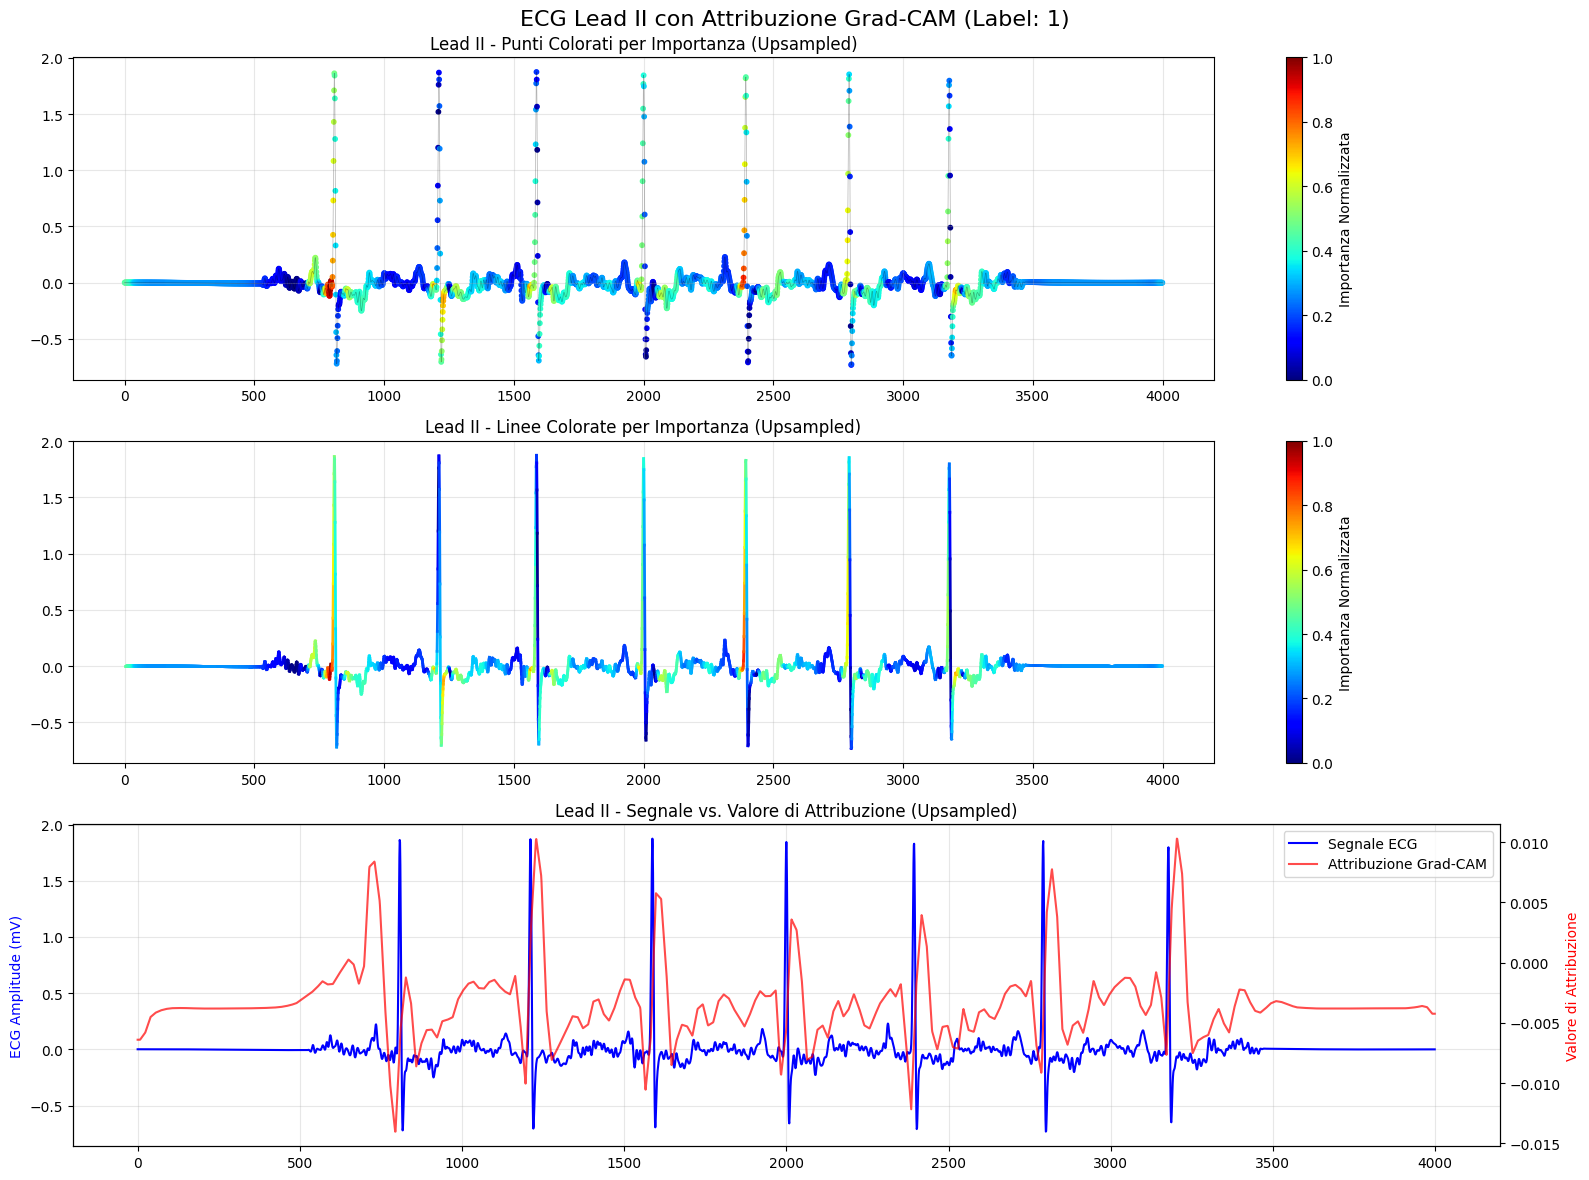

L'attribuzione ha una risoluzione diversa. Eseguo l'upsampling...
Forma attribuzione post-ridimensionamento: torch.Size([4000])


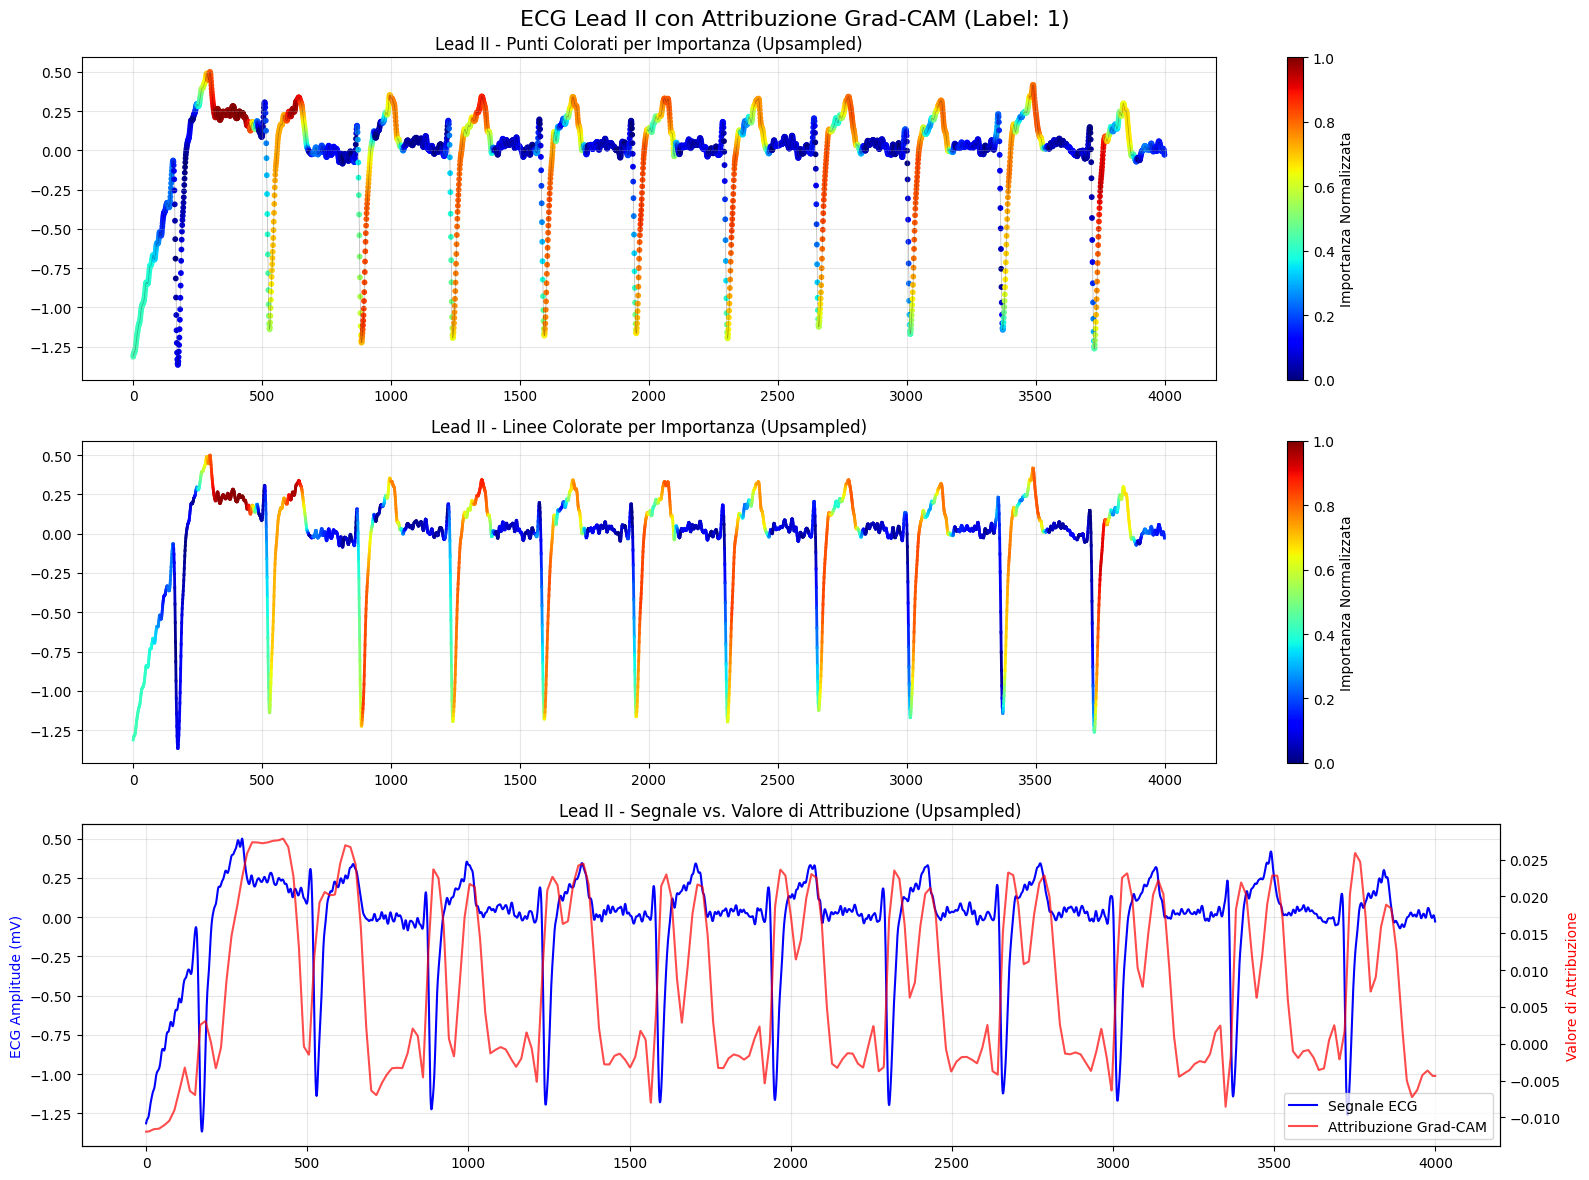

In [ ]:
counter = 0
for X, y in test_loader:
    X, y = X.to(device), y.to(device)

    if y.item() == 1:
        if counter < 5:
            counter += 1
        else:
            break
        
        original_signal = X.cpu().squeeze() # [time, channels]

        # --- APPLICA GRAD-CAM ---
        target_layer = model.ResBlocks[-1]
        lgc = LayerGradCam(model, target_layer)
        
        attribution_map = lgc.attribute(X)
        
        attribution_map_cpu = attribution_map.cpu().squeeze(0).detach()
        attribution_agg = attribution_map_cpu.mean(dim=0)
        
        # Controlliamo se la mappa di attribuzione è più corta del segnale
        if attribution_agg.shape[0] != original_signal.shape[0]:
            attribution_resized = interpolate(
                attribution_agg.unsqueeze(0).unsqueeze(0),
                size=original_signal.shape[0],                 
                mode='linear',                                  
                align_corners=False
            ).squeeze()                                         
        else:
            attribution_resized = attribution_agg

        # --- NORMALIZZAZIONE E PLOT USANDO L'ATTRIBUZIONE RIDIMENSIONATA ---
        attribution_final = attribution_resized # Usiamo questa variabile da ora in poi
        
        attribution_abs = torch.abs(attribution_final)
        attr_min, attr_max = attribution_abs.min(), attribution_abs.max()
        
        if attr_max - attr_min > 1e-8:
            attr_normalized = (attribution_abs - attr_min) / (attr_max - attr_min)
        else:
            attr_normalized = torch.zeros_like(attribution_abs)
        
        # --- VISUALIZZAZIONE ---
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        lead_idx = 1
        lead_name = lead_names[lead_idx]

        time_axis = np.arange(original_signal.shape[0])
        ecg_signal = original_signal[:, lead_idx].numpy()
        
        attr_normalized_np = attr_normalized.numpy()
        attribution_final_np = attribution_final.numpy()

        # Ora le dimensioni corrisponderanno e il plot funzionerà
        fig, axes = plt.subplots(3, 1, figsize=(16, 12))
        fig.suptitle(f'ECG Lead {lead_name} con Attribuzione Grad-CAM (Label: {int(y.item())})', fontsize=16)

        # 1. Scatter plot
        ax1 = axes[0]
        scatter = ax1.scatter(time_axis, ecg_signal, c=attr_normalized_np, cmap='jet', s=10)
        ax1.plot(time_axis, ecg_signal, 'k-', linewidth=0.5, alpha=0.3)
        cbar1 = plt.colorbar(scatter, ax=ax1)
        cbar1.set_label('Importanza Normalizzata')
        ax1.set_title(f'Lead {lead_name} - Punti Colorati per Importanza (Upsampled)')
        ax1.grid(True, alpha=0.3)

        # 2. Linee con gradiente
        ax2 = axes[1]
        for j in range(len(time_axis) - 1):
            color = plt.cm.jet(attr_normalized_np[j])
            ax2.plot(time_axis[j:j+2], ecg_signal[j:j+2], color=color, linewidth=2)
        sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
        cbar2 = plt.colorbar(sm, ax=ax2)
        cbar2.set_label('Importanza Normalizzata')
        ax2.set_title(f'Lead {lead_name} - Linee Colorate per Importanza (Upsampled)')
        ax2.grid(True, alpha=0.3)

        # 3. Segnale vs. Attribuzione
        ax3 = axes[2]
        line1 = ax3.plot(time_axis, ecg_signal, 'b-', label='Segnale ECG')
        ax3.set_ylabel('ECG Amplitude (mV)', color='blue')
        ax3_twin = ax3.twinx()
        line2 = ax3_twin.plot(time_axis, attribution_final_np, 'r-', alpha=0.7, label='Attribuzione Grad-CAM')
        ax3_twin.set_ylabel('Valore di Attribuzione', color='red')
        ax3.legend(line1 + line2, [l.get_label() for l in line1 + line2])
        ax3.set_title(f'Lead {lead_name} - Segnale vs. Valore di Attribuzione (Upsampled)')
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


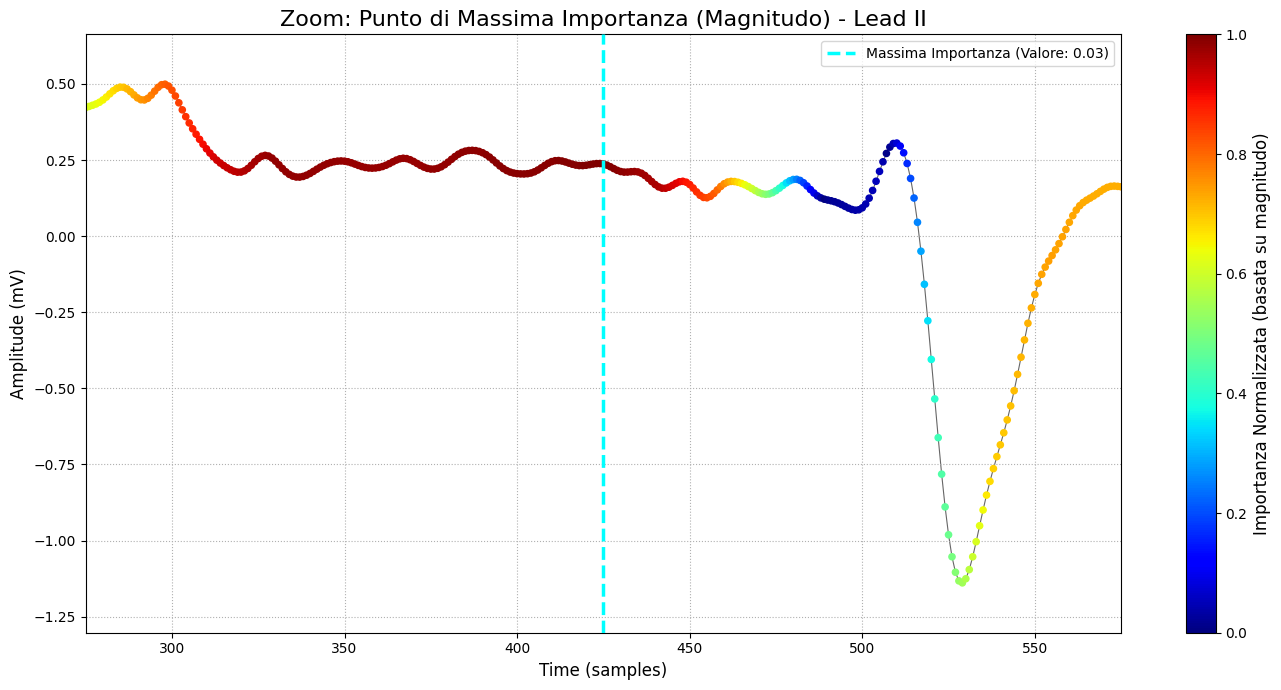

In [19]:
import numpy as np
import matplotlib.pyplot as plt

importance_index = np.argmax(np.abs(attribution_final_np))
importance_value = attribution_final_np[importance_index]


zoom_window = 150 
start_index = max(0, importance_index - zoom_window)
end_index = min(len(time_axis), importance_index + zoom_window)


fig, ax = plt.subplots(figsize=(14, 7))

scatter = ax.scatter(time_axis, ecg_signal, c=attr_normalized_np, cmap='jet', s=20, zorder=2)
ax.plot(time_axis, ecg_signal, 'k-', linewidth=0.8, alpha=0.6, zorder=1)


ax.axvline(x=importance_index, color='cyan', linestyle='--', linewidth=2.5, 
            label=f'Massima Importanza (Valore: {importance_value:.2f})', zorder=3)


ax.set_xlim(start_index, end_index)
zoomed_ecg_segment = ecg_signal[start_index:end_index]
y_padding = (zoomed_ecg_segment.max() - zoomed_ecg_segment.min()) * 0.1
ax.set_ylim(zoomed_ecg_segment.min() - y_padding, zoomed_ecg_segment.max() + y_padding)


ax.set_title(f'Zoom: Punto di Massima Importanza (Magnitudo) - Lead {lead_name}', fontsize=16)
ax.set_xlabel('Time (samples)', fontsize=12)
ax.set_ylabel('Amplitude (mV)', fontsize=12)
ax.legend(loc='upper right')
ax.grid(True, linestyle=':')

cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Importanza Normalizzata (basata su magnitudo)', fontsize=12)

plt.tight_layout()
plt.show()